<a href="https://colab.research.google.com/github/hanan99/CS-SBU-ComputationalNeuroScience2021-projects/blob/main/HananeHabibi-96222029/Assignment1/CN1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from math import exp
from matplotlib import pyplot as plt
from numpy import sin

#**LIF**

In [ ]:
class LIF:
    def __init__(self,dt=0.03125,tau=8,theta=-45,R=10,U_rest=-79,U_reset=-65,U_spike=5,ref_time=0,ref_period=0):
        self.dt = dt
        self.tau = tau
        self.theta = theta
        self.R = R / 1000
        self.U_rest = U_rest
        self.U_reset = U_reset
        self.U_spike = U_spike
        self.ref_time = ref_time
        self.ref_period = ref_period
        self.U = self.U_rest
        self.last_fired = False

    def du(self, I):
        self.U += (-(self.U - self.U_rest) + self.R * I) * self.dt / self.tau

    def fire(self):
        self.last_fired = True
        self.ref_time = self.ref_period
        self.U = self.U_spike

    def simulate_one_step(self, I):
        self.du(I)
        self.ref_time = max(self.ref_time - self.dt, 0)

        if self.last_fired or self.ref_time != 0:
            self.last_fired = False
            self.U = self.U_reset
            return self.U, I

        if self.U >= self.theta:
            self.fire()

        return self.U, I


#**ELIF**

In [ ]:
class ELIF(LIF):
    def __init__(self,theta_rh=-58, delta_t=1, *args,**kwargs):
        super(ELIF, self).__init__(*args, **kwargs)
        self.theta_rh = theta_rh
        self.delta_t = delta_t

    def du(self, I):
        self.U += (-(self.U - self.U_rest) + self.delta_t * (exp((self.U - self.theta_rh) / self.delta_t)) + self.R * I) * self.dt / self.tau





#**AELIF**

In [ ]:
class AELIF(ELIF):
    def __init__(self,a=0.01,b=500,tau_k=100,*args, **kwargs):
        super(AELIF, self).__init__(*args, **kwargs)
        self.a = a * 32.25
        self.b = b * 32.25
        self.tau_k = tau_k
        self.w_k = 0

    def du(self, I):
        def dirac(): return int(self.last_fired)
        old_u = self.U

        self.U += (-(self.U - self.U_rest) + self.delta_t * (exp((self.U - self.theta_rh) / self.delta_t)) + self.R * I - (self.R * self.w_k)) * self.dt / self.tau

        if self.last_fired:
            self.w_k += (self.a * (old_u - self.U_rest) - self.w_k + self.tau_k * self.b) * self.dt / self.tau_k
        else:
            self.w_k += (self.a * (old_u - self.U_rest) - self.w_k) * self.dt / self.tau_k


In [ ]:
def plot_mv_ms(mv, time_list, name=1, top=None, bottom=None):
    plt.plot(time_list, mv)
    plt.ylim(top=top, bottom=bottom)
    plt.ylabel('Membrane Potential (mV)')
    plt.xlabel('Time (ms)')
    if name!=1: name=" for "+name
    name="Voltage-Current"+name
    plt.title(name)
    plt.show()


def plot_current(current, time_list, name=1):
    plt.plot(time_list, current)
    plt.ylabel('Input current (pA)')
    plt.xlabel('Time (ms)')
    if name!=1: name=" for "+name
    name="Time-Current"+name
    plt.title(name)
    plt.show()


def plot_internal_current(current, time_list, name=1):
    plt.plot(time_list, current)
    plt.ylabel('Adaption current (pA)')
    plt.xlabel('Time (ms)')
    if name!=1: name=" for "+name
    name="Time-Adaption Current"+name
    plt.title(name)
    plt.show()


def get_freq_vs_current(type, *args, **kwargs):
    current_list = [i for i in range(1000, 8000, 50)]
    freq_list = []
    for const_I in current_list:
        print("checking with current="+str(const_I))
        U_over_t, _, current = simulate_with_func(
            type, 10000, lambda x: const_I, *args, **kwargs)
        freq_list.append(len([0 for a in U_over_t if a > 0]) / 10000.0)

    plt.plot(current_list, freq_list)
    plt.ylabel('Frequency (KHz)')
    plt.xlabel('Input Current')
    plt.show()


def random_smooth_array(l):
    from numpy import random, array, convolve, ones, linspace
    x=linspace(0, 1000, num=l*10)
    y = 0
    result = []
    for _ in x:
        result.append(y)
        y += random.normal(scale=1)
    r_x=10
    random_array=convolve(array(result), ones((r_x,)) / r_x)[(r_x - 1):]
    return lambda x: abs(random_array[int(x*10)])*200


In [ ]:

total_time_frame = 100
dt = 0.03125
time_steps = int(total_time_frame // dt)

time_list = [i * dt for i in range(time_steps)]  # Total Time Frame / dt

constant_current = lambda x: int(10 <= x) * 3000
random_current = random_smooth_array(time_steps)  # Total Time Frame / dt
step_function_current = lambda x: (int(10 <= x <= 20) * 2000 + int(30 <= x <= 40) * 5000 + int(50 <= x <= 60) * 7000)
sine_wave_current = lambda x: 4000 * (sin(x) + 0.9)
fifth_func = lambda x:( 2500 - (50 - x) ** (2) ) * 3


# **LIF plots** 


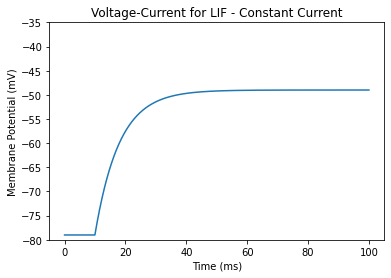

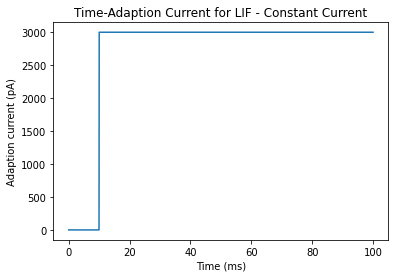

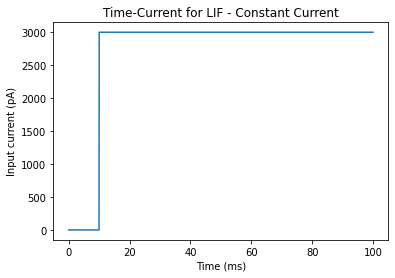

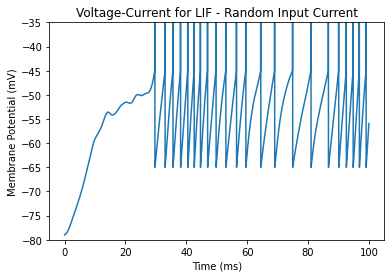

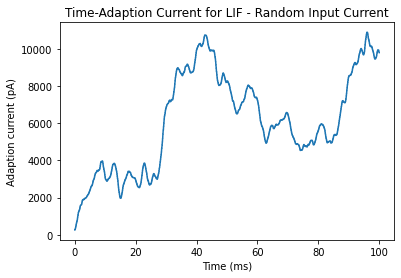

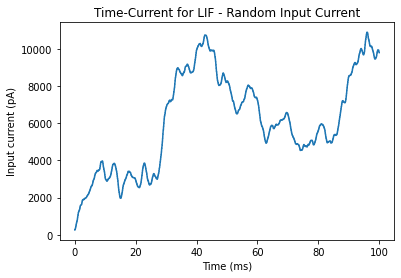

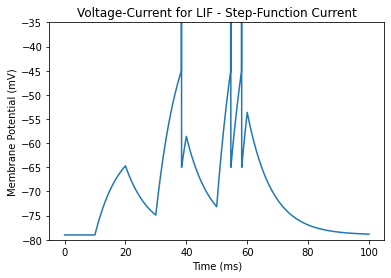

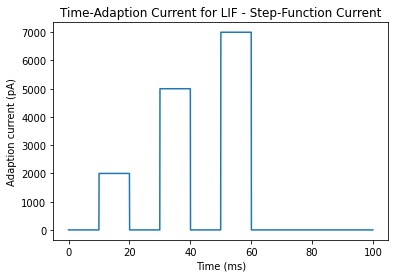

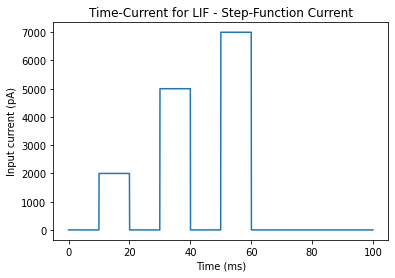

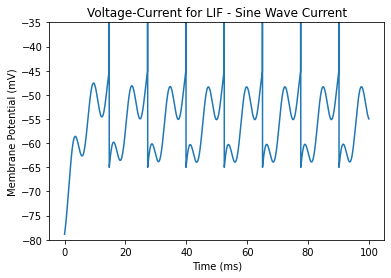

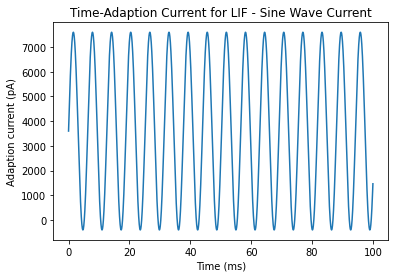

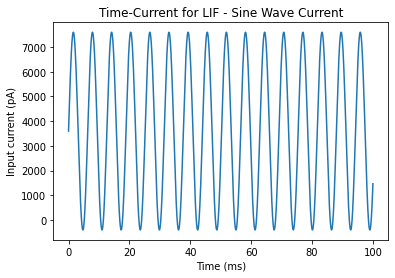

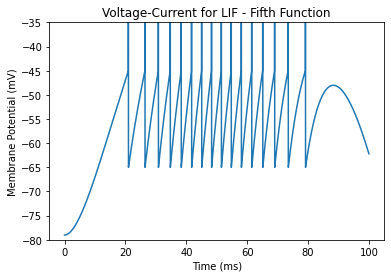

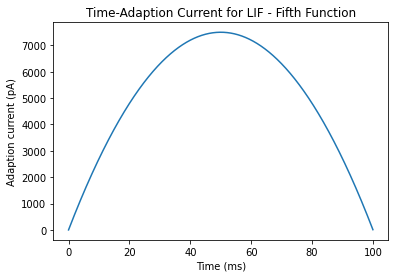

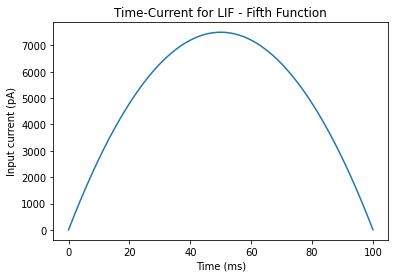

In [ ]:
# get_freq_vs_current(type=" + config[0] +","+ config[1]+")

## Constant Current
neuron = LIF()
U_over_t = []
inter_curr = []
current = [constant_current(t * neuron.dt) for t in range(time_steps)]
for i in current:
    u, w_k = neuron.simulate_one_step(i)
    U_over_t.append(u)
    inter_curr.append(w_k)

title = "LIF - Constant Current"
plot_mv_ms(U_over_t, time_list, name=title, top=-35, bottom=-80)
plot_internal_current(inter_curr, time_list, name=title)
plot_current(current, time_list, name=title)

##------------------------------------------------------------------------##


## Random Input Current
neuron = LIF()
U_over_t = []
inter_curr = []
current = [random_current(t * neuron.dt) for t in range(time_steps)]
for i in current:
    u, w_k = neuron.simulate_one_step(i)
    U_over_t.append(u)
    inter_curr.append(w_k)

title = "LIF - Random Input Current"
plot_mv_ms(U_over_t, time_list, name=title, top=-35, bottom=-80)
plot_internal_current(inter_curr, time_list, name=title)
plot_current(current, time_list, name=title)


##------------------------------------------------------------------------##


## Step-Function Current
neuron = LIF()
U_over_t = []
inter_curr = []
current = [step_function_current(t * neuron.dt) for t in range(time_steps)]
for i in current:
    u, w_k = neuron.simulate_one_step(i)
    U_over_t.append(u)
    inter_curr.append(w_k)

title = "LIF - Step-Function Current"
plot_mv_ms(U_over_t, time_list, name=title, top=-35, bottom=-80)
plot_internal_current(inter_curr, time_list, name=title)
plot_current(current, time_list, name=title)

##------------------------------------------------------------------------##


## Sine Wave Current
neuron = LIF()
U_over_t = []
inter_curr = []
current = [sine_wave_current(t * neuron.dt) for t in range(time_steps)]
for i in current:
    u, w_k = neuron.simulate_one_step(i)
    U_over_t.append(u)
    inter_curr.append(w_k)

title = "LIF - Sine Wave Current"
plot_mv_ms(U_over_t, time_list, name=title, top=-35, bottom=-80)
plot_internal_current(inter_curr, time_list, name=title)
plot_current(current, time_list, name=title)


##------------------------------------------------------------------------##


## Fifth Function
neuron = LIF()
U_over_t = []
inter_curr = []
current = [fifth_func(t * neuron.dt) for t in range(time_steps)]
for i in current:
    u, w_k = neuron.simulate_one_step(i)
    U_over_t.append(u)
    inter_curr.append(w_k)

title = "LIF - Fifth Function"
plot_mv_ms(U_over_t, time_list, name=title, top=-35, bottom=-80)
plot_internal_current(inter_curr, time_list, name=title)
plot_current(current, time_list, name=title)


#**ELIF plots**


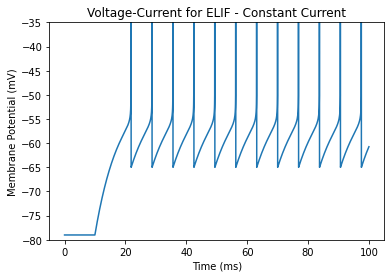

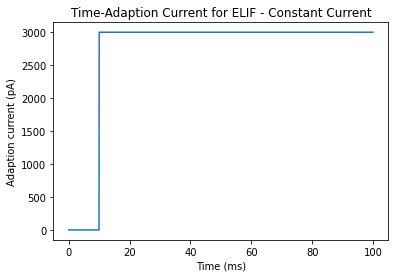

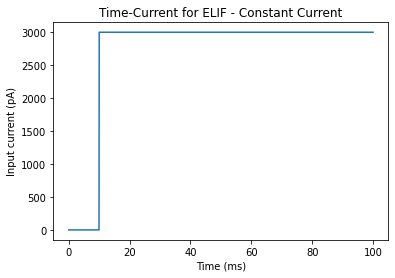

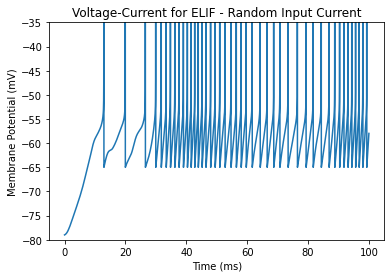

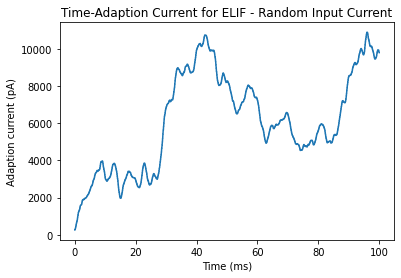

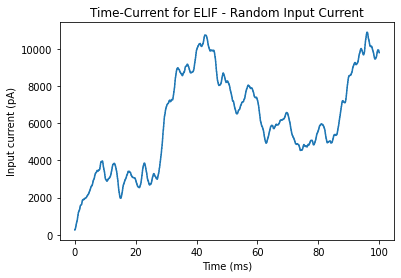

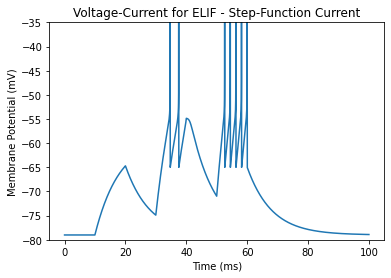

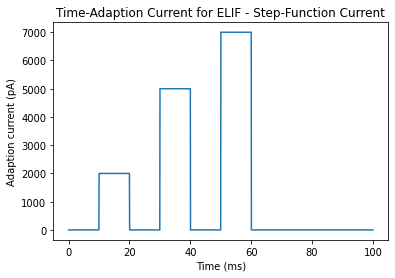

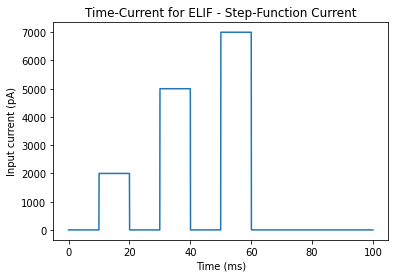

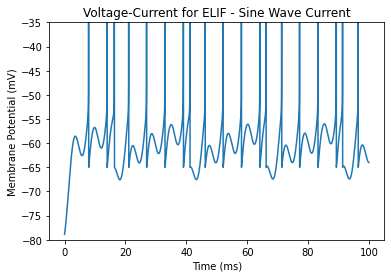

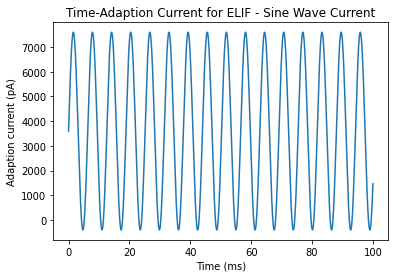

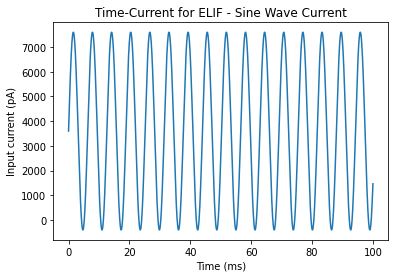

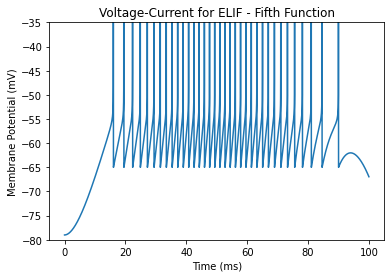

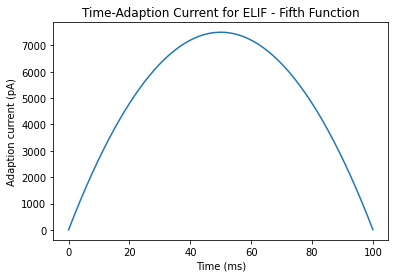

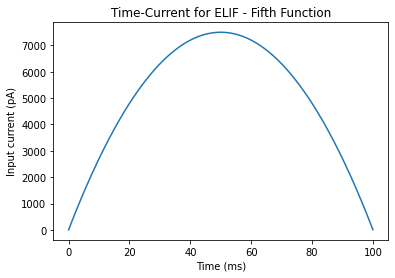

In [ ]:
## Constant Current
neuron = ELIF()
U_over_t = []
inter_curr = []
current = [constant_current(t * neuron.dt) for t in range(time_steps)]
for i in current:
    u, w_k = neuron.simulate_one_step(i)
    U_over_t.append(u)
    inter_curr.append(w_k)

title = "ELIF - Constant Current"
plot_mv_ms(U_over_t, time_list, name=title, top=-35, bottom=-80)
plot_internal_current(inter_curr, time_list, name=title)
plot_current(current, time_list, name=title)


##------------------------------------------------------------------------##

## Random Input Current
neuron = ELIF()
U_over_t = []
inter_curr = []
current = [random_current(t * neuron.dt) for t in range(time_steps)]
for i in current:
    u, w_k = neuron.simulate_one_step(i)
    U_over_t.append(u)
    inter_curr.append(w_k)

title = "ELIF - Random Input Current"
plot_mv_ms(U_over_t, time_list, name=title, top=-35, bottom=-80)
plot_internal_current(inter_curr, time_list, name=title)
plot_current(current, time_list, name=title)


##------------------------------------------------------------------------##


## Step-Function Current
neuron = ELIF()
U_over_t = []
inter_curr = []
current = [step_function_current(t * neuron.dt) for t in range(time_steps)]
for i in current:
    u, w_k = neuron.simulate_one_step(i)
    U_over_t.append(u)
    inter_curr.append(w_k)

title = "ELIF - Step-Function Current"
plot_mv_ms(U_over_t, time_list, name=title, top=-35, bottom=-80)
plot_internal_current(inter_curr, time_list, name=title)
plot_current(current, time_list, name=title)

##------------------------------------------------------------------------##


## Sine Wave Current
neuron = ELIF()
U_over_t = []
inter_curr = []
current = [sine_wave_current(t * neuron.dt) for t in range(time_steps)]
for i in current:
    u, w_k = neuron.simulate_one_step(i)
    U_over_t.append(u)
    inter_curr.append(w_k)

title = "ELIF - Sine Wave Current"
plot_mv_ms(U_over_t, time_list, name=title, top=-35, bottom=-80)
plot_internal_current(inter_curr, time_list, name=title)
plot_current(current, time_list, name=title)

##------------------------------------------------------------------------##


## Fifth Function
neuron = ELIF()
U_over_t = []
inter_curr = []
current = [fifth_func(t * neuron.dt) for t in range(time_steps)]
for i in current:
    u, w_k = neuron.simulate_one_step(i)
    U_over_t.append(u)
    inter_curr.append(w_k)

title = "ELIF - Fifth Function"
plot_mv_ms(U_over_t, time_list, name=title, top=-35, bottom=-80)
plot_internal_current(inter_curr, time_list, name=title)
plot_current(current, time_list, name=title)


#**AELIF plots**


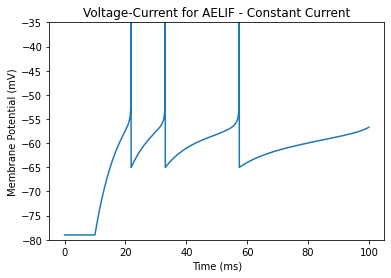

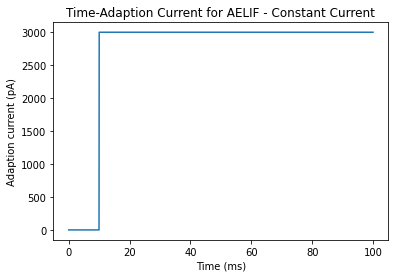

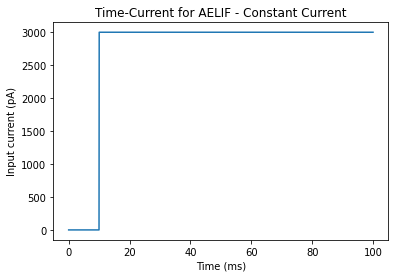

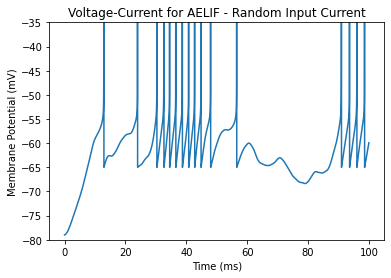

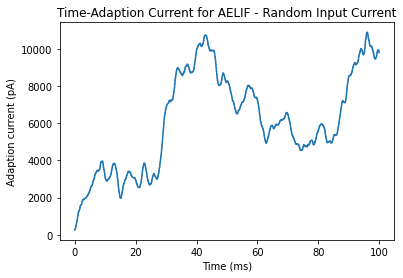

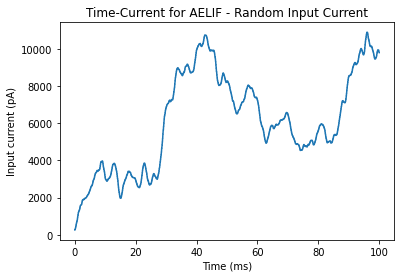

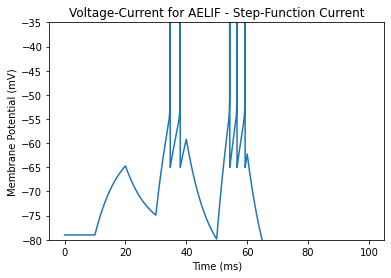

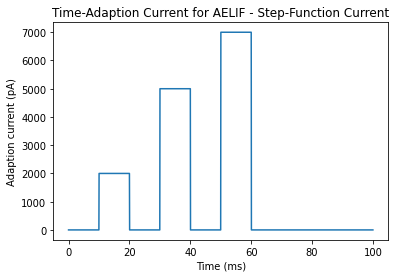

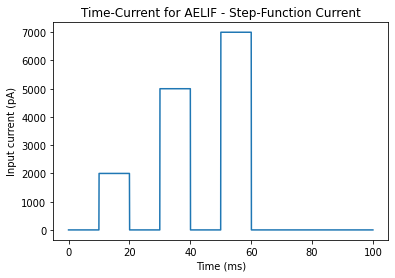

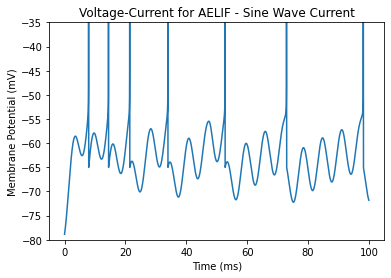

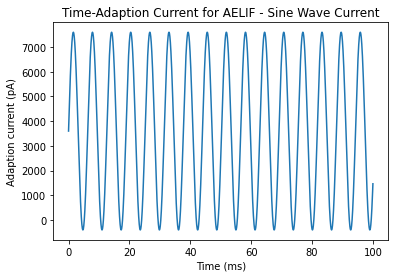

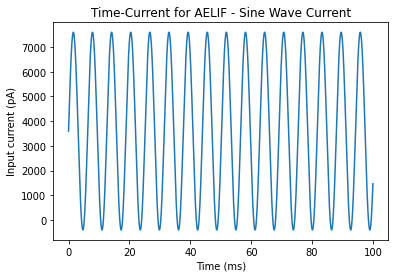

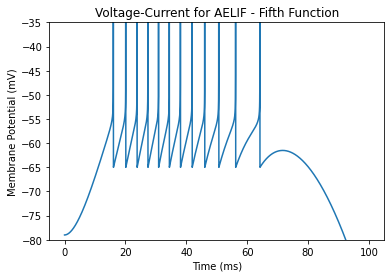

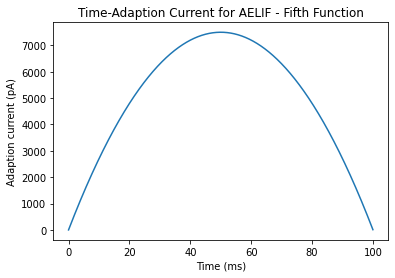

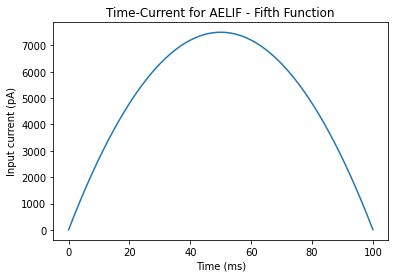

In [ ]:

## Constant Current
neuron = AELIF()
U_over_t = []
inter_curr = []
current = [constant_current(t * neuron.dt) for t in range(time_steps)]
for i in current:
    u, w_k = neuron.simulate_one_step(i)
    U_over_t.append(u)
    inter_curr.append(w_k)

title = "AELIF - Constant Current"
plot_mv_ms(U_over_t, time_list, name=title, top=-35, bottom=-80)
plot_internal_current(inter_curr, time_list, name=title)
plot_current(current, time_list, name=title)

##------------------------------------------------------------------------##

## Random Input Current
neuron = AELIF()
U_over_t = []
inter_curr = []
current = [random_current(t * neuron.dt) for t in range(time_steps)]
for i in current:
    u, w_k = neuron.simulate_one_step(i)
    U_over_t.append(u)
    inter_curr.append(w_k)

title = "AELIF - Random Input Current"
plot_mv_ms(U_over_t, time_list, name=title, top=-35, bottom=-80)
plot_internal_current(inter_curr, time_list, name=title)
plot_current(current, time_list, name=title)

##-----------------------------------------------------------------##

## Step-Function Current
neuron = AELIF()
U_over_t = []
inter_curr = []
current = [step_function_current(t * neuron.dt) for t in range(time_steps)]
for i in current:
    u, w_k = neuron.simulate_one_step(i)
    U_over_t.append(u)
    inter_curr.append(w_k)

title = "AELIF - Step-Function Current"
plot_mv_ms(U_over_t, time_list, name=title, top=-35, bottom=-80)
plot_internal_current(inter_curr, time_list, name=title)
plot_current(current, time_list, name=title)


##-----------------------------------------------------------------------##

## Sine Wave Current
neuron = AELIF()
U_over_t = []
inter_curr = []
current = [sine_wave_current(t * neuron.dt) for t in range(time_steps)]
for i in current:
    u, w_k = neuron.simulate_one_step(i)
    U_over_t.append(u)
    inter_curr.append(w_k)

title = "AELIF - Sine Wave Current"
plot_mv_ms(U_over_t, time_list, name=title, top=-35, bottom=-80)
plot_internal_current(inter_curr, time_list, name=title)
plot_current(current, time_list, name=title)


##------------------------------------------------------------------------##


## Fifth Function
neuron = AELIF()
U_over_t = []
inter_curr = []
current = [fifth_func(t * neuron.dt) for t in range(time_steps)]
for i in current:
    u, w_k = neuron.simulate_one_step(i)
    U_over_t.append(u)
    inter_curr.append(w_k)

title = "AELIF - Fifth Function"
plot_mv_ms(U_over_t, time_list, name=title, top=-35, bottom=-80)
plot_internal_current(inter_curr, time_list, name=title)
plot_current(current, time_list, name=title)
